### MNIST Dataset - Classification Using MLP

#### $Necessary$ $Imports$


In [1]:
import numpy as np
import struct
from array import array
from os.path import join
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pprint import pprint
from einops import rearrange

from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### $MNIST$ $Dataloader$ $Class$

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

#### $Function$ $to$ $Plot$ $Images$

In [3]:
def show_images(images, title_texts, suptitle = None):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    plt.suptitle(suptitle, fontsize = 30)
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap='gray')
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#### $MNIST$ $Data$ 

In [4]:
x_train_path = './MNIST_Data/train-images-idx3-ubyte/train-images-idx3-ubyte'
y_train_path = './MNIST_Data/train-labels-idx1-ubyte/train-labels-idx1-ubyte'
x_test_path = './MNIST_Data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
y_test_path = './MNIST_Data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

In [5]:
mnist_dataloader = MnistDataloader(x_train_path, y_train_path, x_test_path, y_test_path)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [6]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)
print(f"x_train shape: {x_train_np.shape}, y_train shape: {y_train_np.shape}\nx_test shape: {x_test_np.shape}, y_test shape: {y_test_np.shape}")

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


In [7]:
x_train_np_reshaped = x_train_np.reshape(-1, 28*28)
x_test_np_reshaped = x_test_np.reshape(-1, 28*28)
print(f"x_train reshaped: {x_train_np_reshaped.shape}\n x_test reshaped: {x_test_np_reshaped.shape}")

x_train reshaped: (60000, 784)
 x_test reshaped: (10000, 784)


In [8]:
x_train_t = torch.tensor(x_train_np).float().to(device)
y_train_t = torch.tensor(y_train_np).to(device)
x_test_t = torch.tensor(x_test_np).float().to(device)
y_test_t = torch.tensor(y_test_np).to(device)

In [9]:
x_train_t_reshaped = torch.tensor(x_train_np_reshaped).float().to(device)
x_test_t_reshaped = torch.tensor(x_test_np_reshaped).float().to(device)
print(f"x_train reshaped: {x_train_t_reshaped.shape}\nx_test reshaped: {x_test_t_reshaped.shape}")

x_train reshaped: torch.Size([60000, 784])
x_test reshaped: torch.Size([10000, 784])


#### $Plotting$ $Some$ $Images$ $from$ $MNIST$ $Dataset$

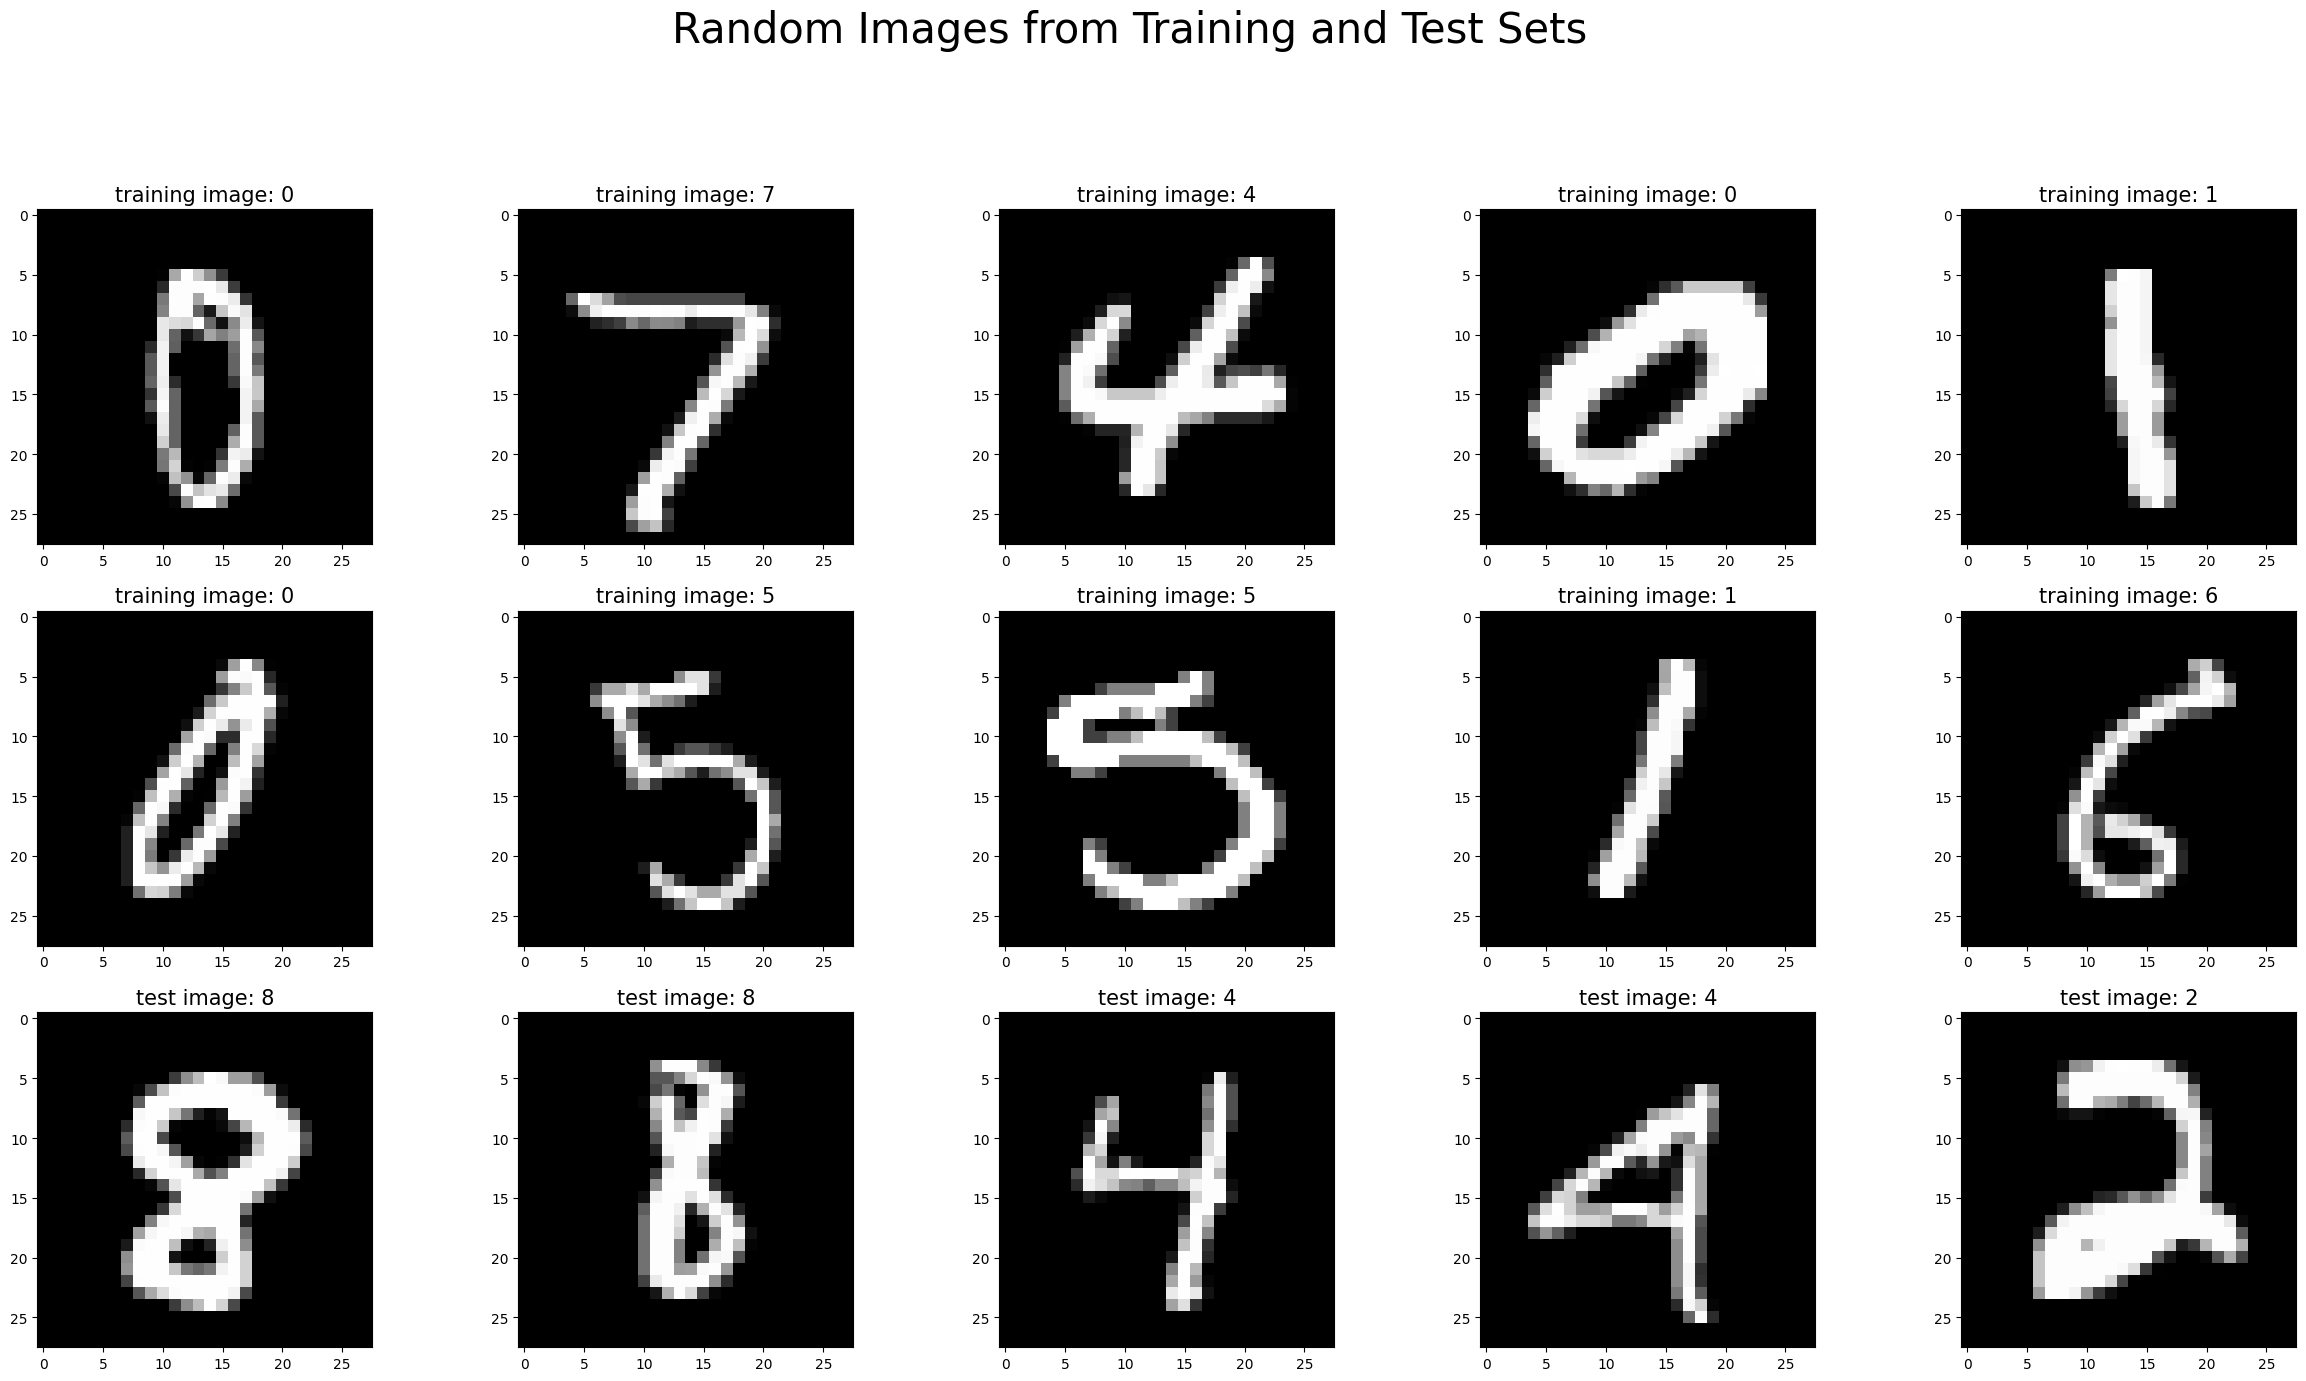

In [10]:
images = []
titles = []
for i in range(10):
    r = random.randint(1, 60000)
    images.append(x_train_np[r])
    titles.append(f"training image: {y_train_np[r]}")
for i in range(5):
    r = random.randint(1, 10000)
    images.append(x_test_np[r])
    titles.append(f"test image: {y_test_np[r]}")
show_images(images, titles, "Random Images from Training and Test Sets")

#### $Neural$ $Network$ $Class$

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### $Train$ $Function$

In [12]:
def train(model, x_train, y_train, epochs, batch_size, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'loss':[], 'accuracy':[]}
    for epoch in range(epochs):
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        output = model(x_train)
        loss = criterion(output, y_train)
        history['loss'].append(loss.item())
        history['accuracy'].append(accuracy_score(y_train.cpu().numpy(), output.argmax(dim=1).cpu().numpy()))
        
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}, Accuracy: {history['accuracy'][-1]}")
    return history

#### $Function$ $to$ $Plot$ $Training$ $Loss$ $and$ $Accuracy$ $Graphs$

In [13]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    ax[0].plot(history["loss"], label="Loss")
    ax[0].set_title("Training Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    ax[1].plot(history["accuracy"], label="Accuracy")
    ax[1].set_title("Training Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    
    plt.show()

#### $Function$ $to$ $Predict$ $Images$

In [14]:
def predict(model, x):
    with torch.no_grad():
        output = model(x)
    return torch.argmax(output, 1)

#### $Function$ $to$ $Plot$ $Confusion$ $Matrix$

In [15]:
def plot_confusion_matrix(y_true, y_pred, lables = None):
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=lables, yticklabels=lables)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

#### $Function$ $to$ $Calculate$ $Comparison$ $Metrics$

In [16]:
def evaluate_model(y_test,y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

#### $Function$ $to$ $Visualize$ $the$ $t-Distributed$ $Stochastic$ $Neighbor$ $Embedding$ $of$ $a$ $Layer$

In [17]:
def tsne_plot(model, x, y, title="t-SNE Plot"):
    output = model.fc2(F.relu(model.fc1(x)))
    tsne = TSNE(n_components=2, random_state=0)
    x_2d = tsne.fit_transform(output.cpu().detach().numpy())
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=x_2d[:, 0], y=x_2d[:, 1], hue=y.cpu().numpy(), palette="tab10")
    plt.title(title)
    plt.show()    

#### $t-SNE$ $Visualization$ $of$ $the$ $Last$ $Layer$ $of$ $the$ $Untrained$ $Network$

In [18]:
mlp = NeuralNetwork().to(device)

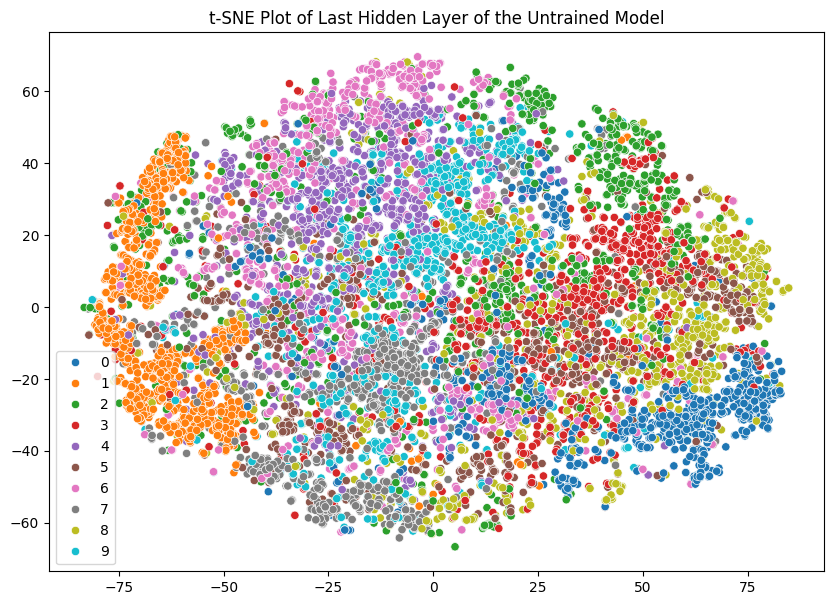

In [19]:
tsne_plot(mlp, x_test_t_reshaped, y_test_t, "t-SNE Plot of Last Hidden Layer of the Untrained Model")

#### $Training$ $the$ $Network$

In [20]:
history = train(mlp, x_train_t_reshaped, y_train_t, epochs=10, batch_size=1000, lr=0.001)

Epoch: 1, Loss: 0.6943541169166565, Accuracy: 0.7905166666666666
Epoch: 2, Loss: 0.43439096212387085, Accuracy: 0.8768833333333333
Epoch: 3, Loss: 0.33226966857910156, Accuracy: 0.9053333333333333
Epoch: 4, Loss: 0.2799887955188751, Accuracy: 0.9188333333333333
Epoch: 5, Loss: 0.24987582862377167, Accuracy: 0.9268833333333333
Epoch: 6, Loss: 0.22852569818496704, Accuracy: 0.9330333333333334
Epoch: 7, Loss: 0.21325421333312988, Accuracy: 0.9372
Epoch: 8, Loss: 0.2009114921092987, Accuracy: 0.9400166666666666
Epoch: 9, Loss: 0.18716596066951752, Accuracy: 0.9435833333333333
Epoch: 10, Loss: 0.17692886292934418, Accuracy: 0.9468666666666666


#### $Plotting$ $the$ $Training$ $Loss$ $and$ $Accuracy$ $Graphs$

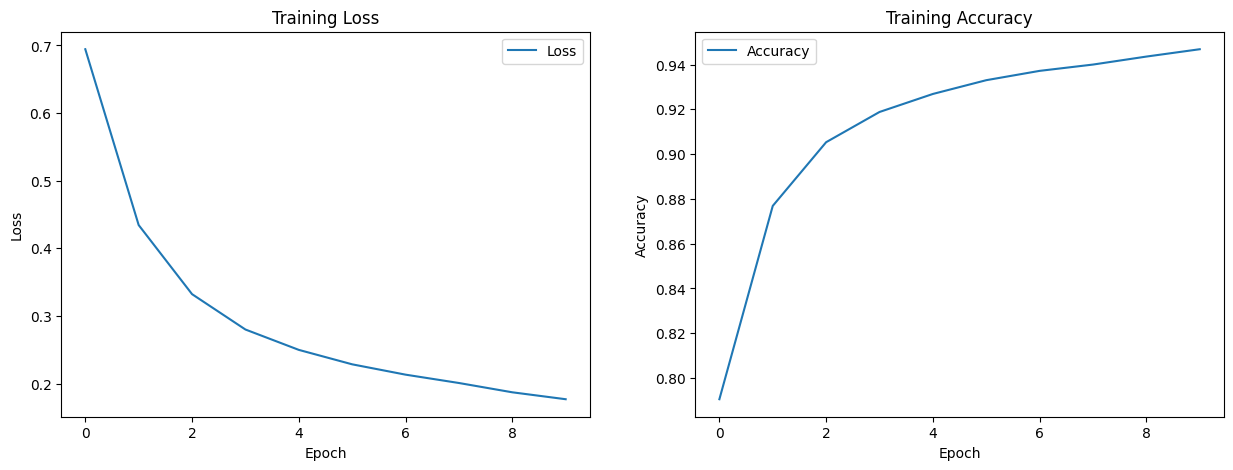

In [21]:
plot_training_history(history)

#### $Predicting$ $the$ $Images$

In [22]:
y_pred_t = predict(mlp, x_test_t_reshaped)

#### $Different$ $Metrics$ $for$ $Comparison$

In [23]:
evaluate_model(y_test_t.cpu().numpy(), y_pred_t.cpu().numpy())

Accuracy: 0.937
Precision: 0.937627636626407
F1 Score: 0.9370439295941589


#### $Plotting$ $the$ $Confusion$ $Matrix$

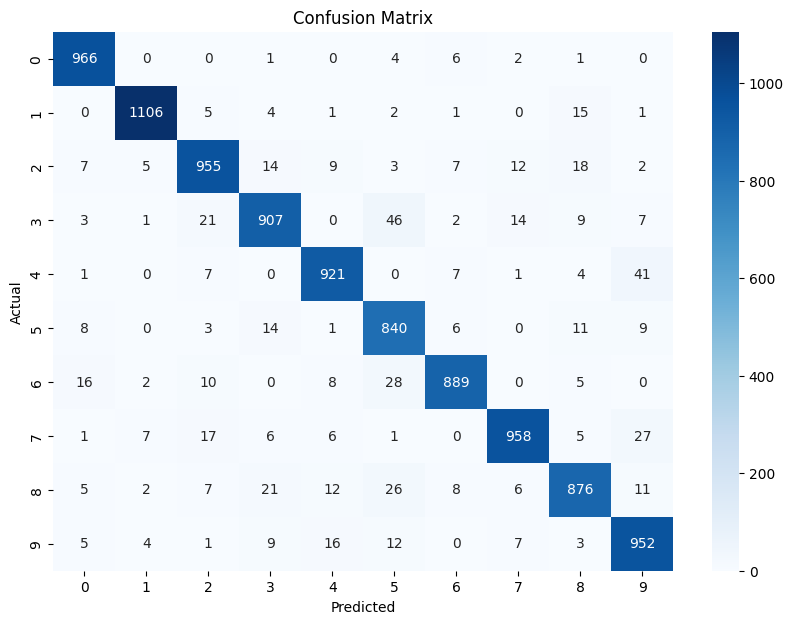

In [24]:
plot_confusion_matrix(y_test_t, y_pred_t, [str(i) for i in range(10)])

#### $t-SNE$ $Visualization$ $of$ $the$ $Last$ $Layer$ $of$ $the$ $Trained$ $Network$

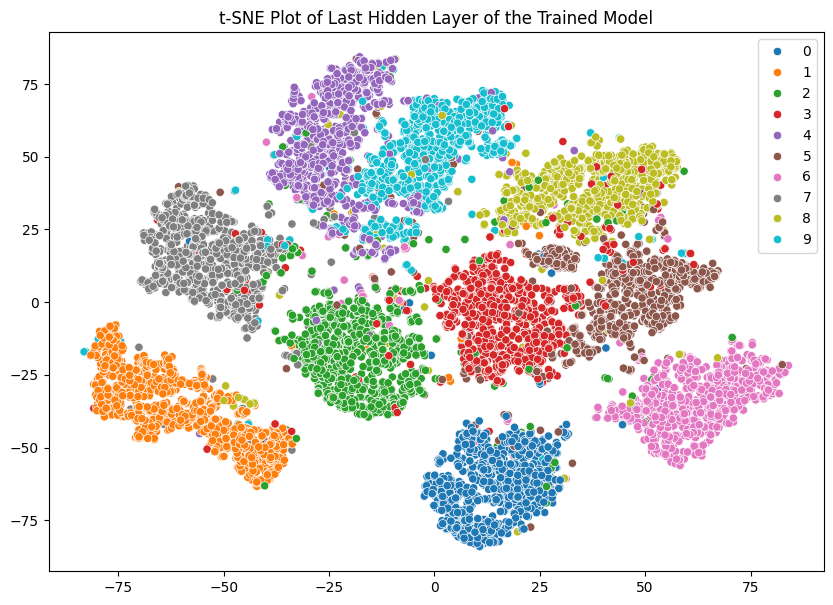

In [25]:
tsne_plot(mlp, x_test_t_reshaped, y_test_t, "t-SNE Plot of Last Hidden Layer of the Trained Model")

#### $Observations$

On observing the $t-SNE$ visualization of the last layer of the untrained and trained network, we can see that before learning the dataset, the embeddings are scattered all over the place. But after training, the embeddings are grouped together and are well separated. This shows that the network has learned the dataset and is able to classify the images correctly.

We can also see that the clusters for $'4'$ and $'9'$ are very close to each other. This is because the images of $'4'$ and $'9'$ are very similar and it is difficult to classify them. This is also reflected in the confusion matrix where we can see that the model has misclassified many $'4'$ as $'9'$ and vice versa.

#### $Comparing$ $the$ $Results$ $with$ $the$ $Random$ $Forest$ $Classifier$

In [26]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)
rf.fit(x_train_np_reshaped, y_train_np)
y_pred_rf = rf.predict(x_test_np_reshaped)
evaluate_model(y_test_np, y_pred_rf)

Accuracy: 0.9667
Precision: 0.9667044151422945
F1 Score: 0.9666825720514376


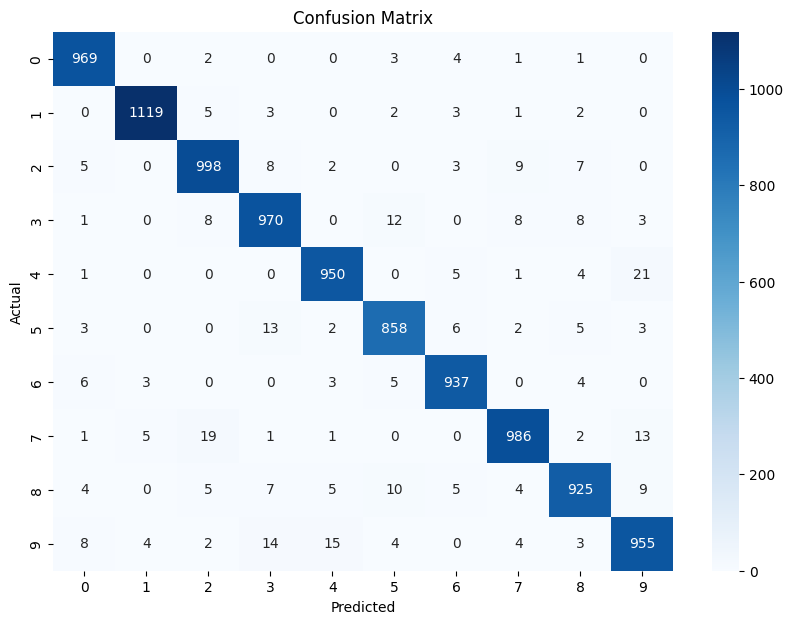

In [27]:
plot_confusion_matrix(y_test_t, torch.tensor(y_pred_rf), [str(i) for i in range(10)])

#### $Comparing$ $the$ $Results$ $with$ $the$ $Logistic$ $Regression$ $Classifier$

In [28]:
log_reg = LogisticRegression(random_state=0, max_iter=10)
log_reg.fit(x_train_np_reshaped, y_train_np)
y_pred_log_reg = log_reg.predict(x_test_np_reshaped)
evaluate_model(y_test_np, y_pred_log_reg)

Accuracy: 0.8888
Precision: 0.8890058655593701
F1 Score: 0.8885322308277733


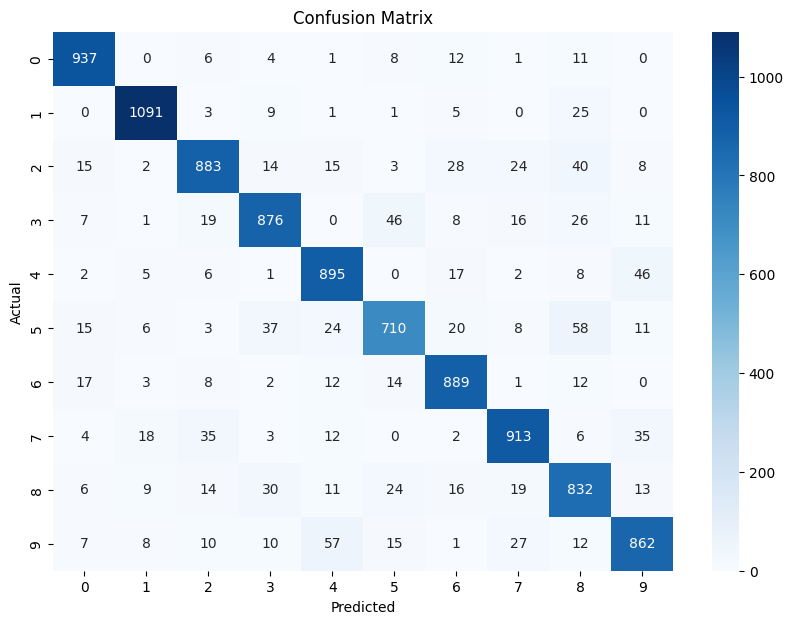

In [29]:
plot_confusion_matrix(y_test_t, torch.tensor(y_pred_log_reg), [str(i) for i in range(10)])

#### $Observations$

**Comparison between Results of these models:** The accuracy of the Random Forest Classifier turns out to be greater than that of the Neural Network. This could be due to the fact that the number of neurons in the network is less and the network is not deep enough to learn the dataset. But the accuracy of Logistic Regression is less than that of both the other models depicting that the dataset is not completely linearly separable.

**Most Commonly Confused Images:** If we compare the confusion matrix for all the models, we can see that the most commonly confused images are $'4'$ and $'9'$. This is because the images of $'4'$ and $'9'$ are quite similar and it is difficult to classify them. Some other images that the model is confused with are $'3'$ and $'5'$, $'3'$ and $'9'$ as they have similar structure.

### $Testing$ $the$ $Trained$ $Model$ $on$ $Fashion$ $MNIST$ $Dataset$

#### $Loading$ $the$ $Fashion-MNIST$ $Dataset$

In [30]:
x_train_path = './fashion_MNIST/train-images-idx3-ubyte'
y_train_path = './fashion_MNIST/train-labels-idx1-ubyte'
x_test_path = './fashion_MNIST/t10k-images-idx3-ubyte'
y_test_path = './fashion_MNIST/t10k-labels-idx1-ubyte'

In [31]:
mnist_dataloader = MnistDataloader(x_train_path, y_train_path, x_test_path, y_test_path)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [32]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)
print(f"x_train shape: {x_train_np.shape}, y_train shape: {y_train_np.shape}\nx_test shape: {x_test_np.shape}, y_test shape: {y_test_np.shape}")

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


In [33]:
x_train_np_reshaped = x_train_np.reshape(-1, 28*28)
x_test_np_reshaped = x_test_np.reshape(-1, 28*28)
print(f"x_train reshaped: {x_train_np_reshaped.shape}\n x_test reshaped: {x_test_np_reshaped.shape}")

x_train reshaped: (60000, 784)
 x_test reshaped: (10000, 784)


In [34]:
x_train_t = torch.tensor(x_train_np).float().to(device)
y_train_t = torch.tensor(y_train_np).to(device)
x_test_t = torch.tensor(x_test_np).float().to(device)
y_test_t = torch.tensor(y_test_np).to(device)

In [35]:
x_train_t_reshaped = torch.tensor(x_train_np_reshaped).float().to(device)
x_test_t_reshaped = torch.tensor(x_test_np_reshaped).float().to(device)
print(f"x_train reshaped: {x_train_t_reshaped.shape}\nx_test reshaped: {x_test_t_reshaped.shape}")

x_train reshaped: torch.Size([60000, 784])
x_test reshaped: torch.Size([10000, 784])


#### $Plotting$ $Some$ $Images$ $from$ $Fashion-MNIST$ $Dataset$

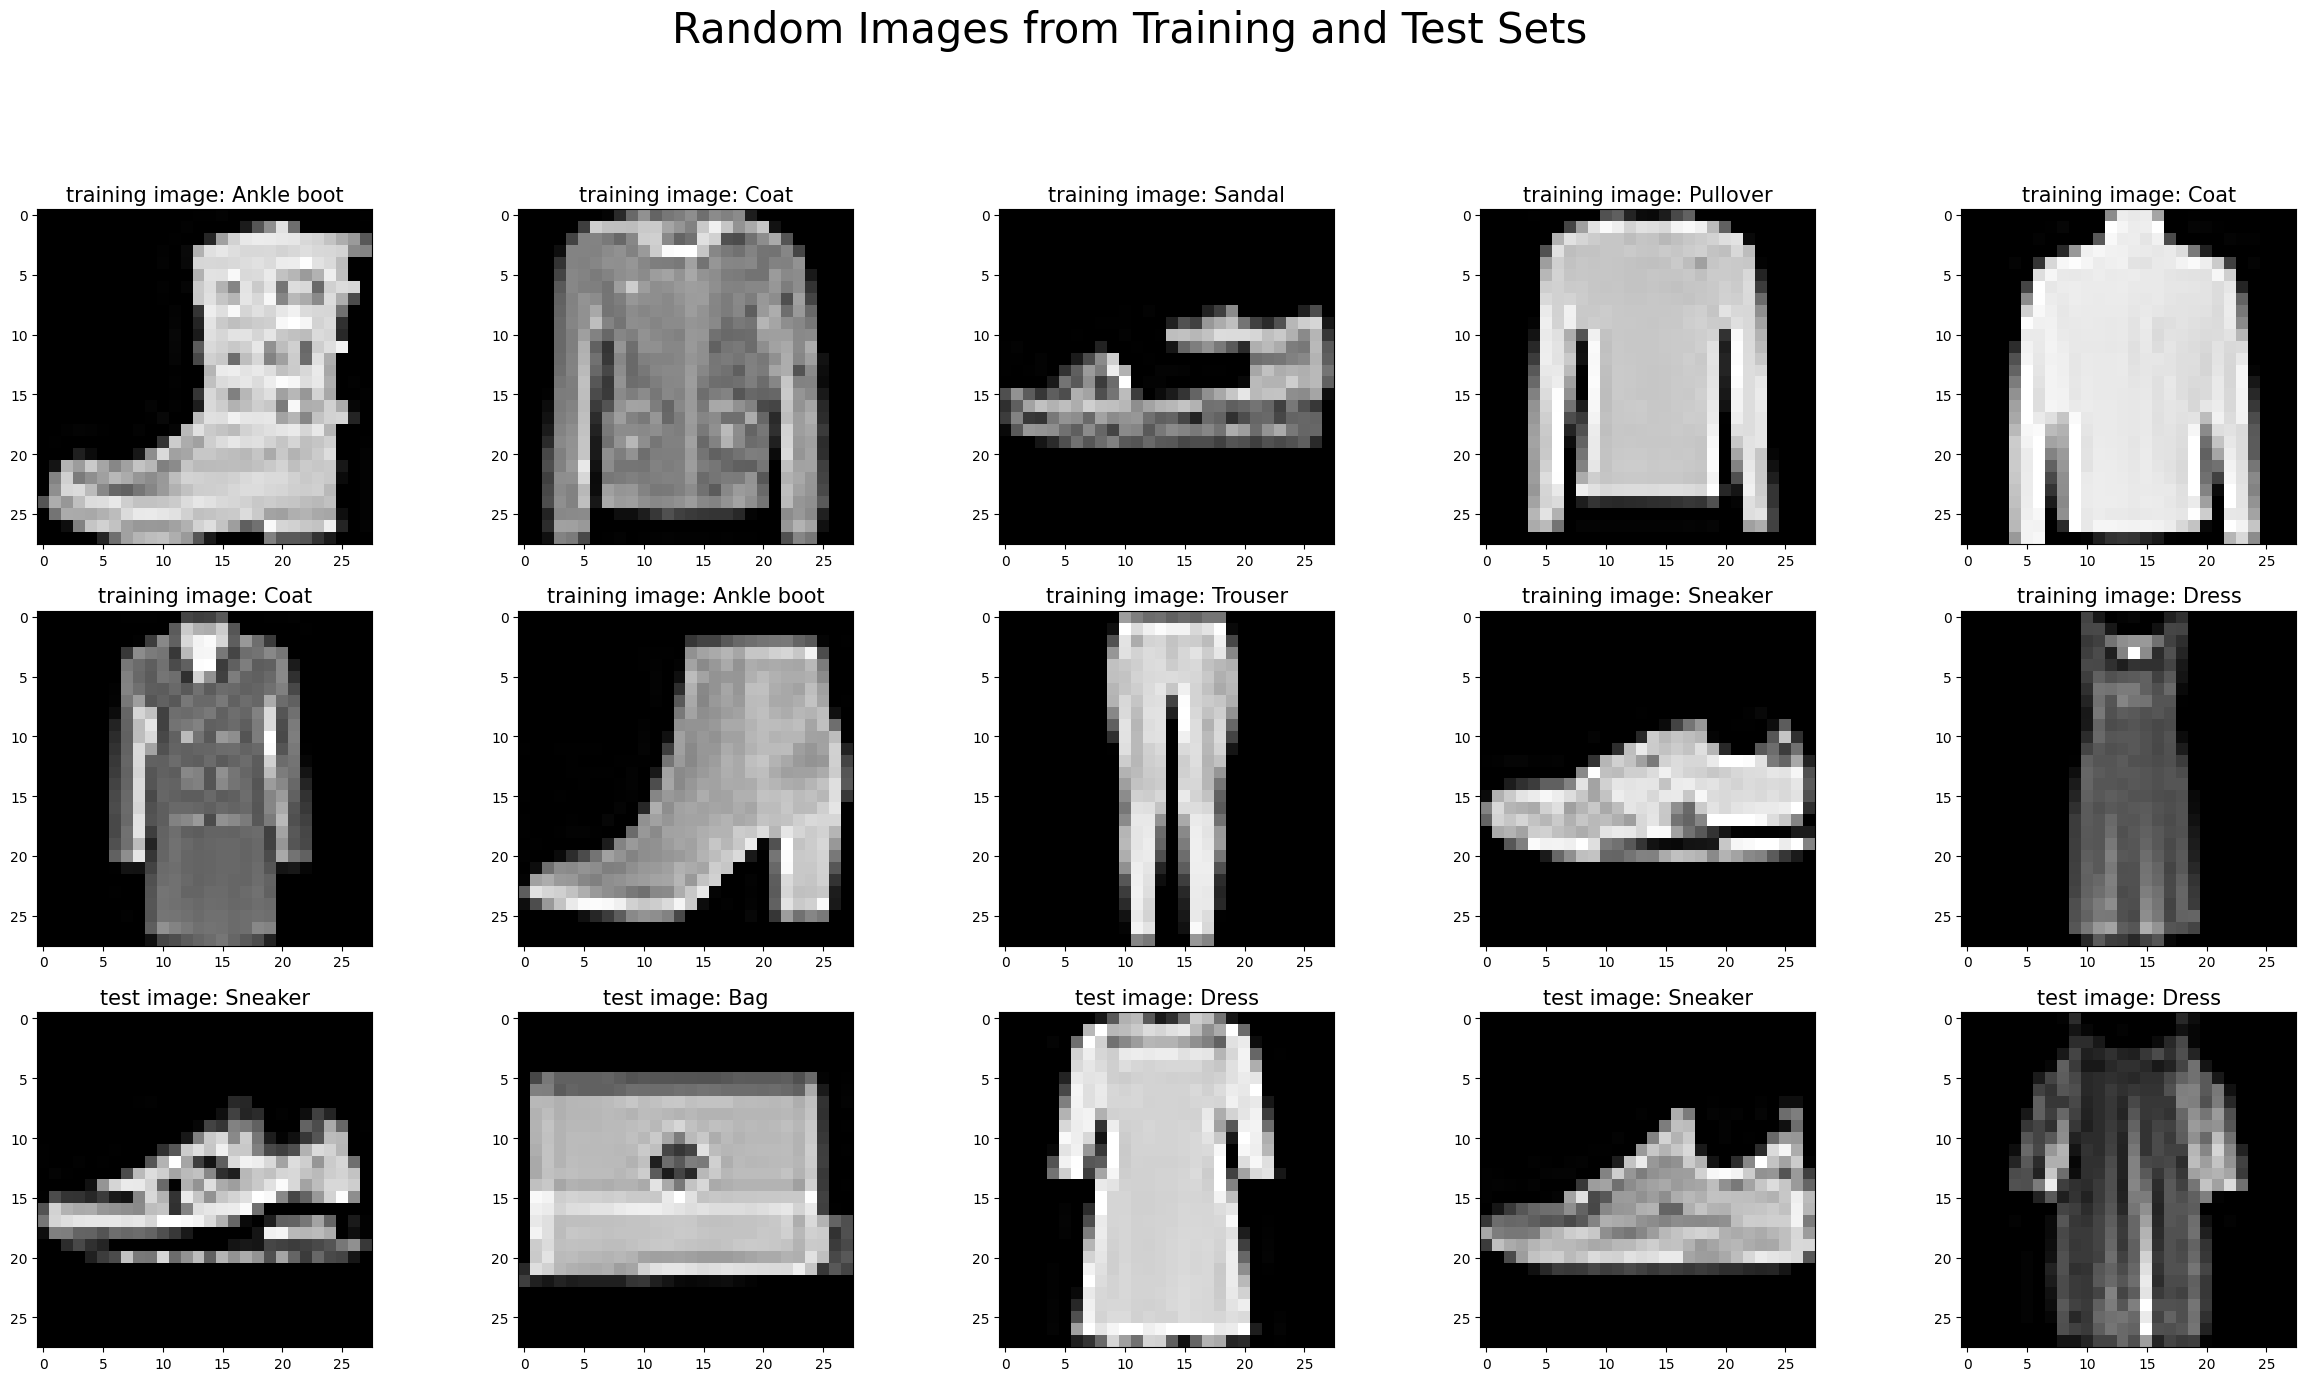

In [36]:
images = []
titles = []
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for i in range(10):
    r = random.randint(1, 60000)
    images.append(x_train_np[r])
    titles.append(f"training image: {labels[y_train_np[r]]}")
for i in range(5):
    r = random.randint(1, 10000)
    images.append(x_test_np[r])
    titles.append(f"test image: {labels[y_test_np[r]]}")
show_images(images, titles, "Random Images from Training and Test Sets")
    


#### $Using$ $the$ $Trained$ $Network$ $to$ $Predict$ $Images$ $from$ $Fashion-MNIST$ $Dataset$

In [37]:
y_pred_t = predict(mlp, x_test_t_reshaped)

#### $Metrics$ $for$ $Comparison$

In [38]:
evaluate_model(y_test_t.cpu().numpy(), y_pred_t.cpu().numpy())

Accuracy: 0.1144
Precision: 0.13806315549687573
F1 Score: 0.06980255573229914


#### $Confusion$ $Matrix$ $for$ $Fashion-MNIST$ $Dataset$

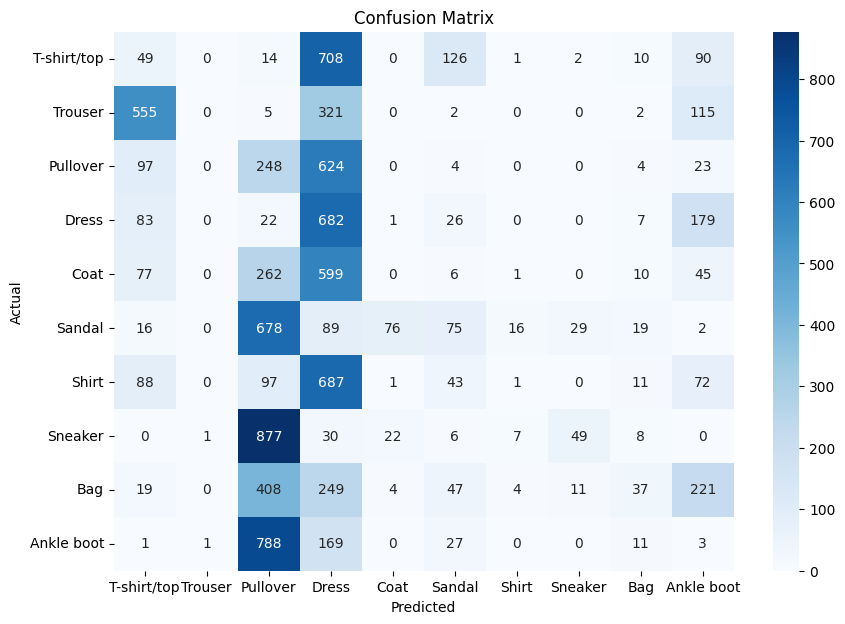

In [39]:
plot_confusion_matrix(y_test_t, y_pred_t, labels)

#### $t-SNE$ $Visualization$ $of$ $the$ $Last$ $Layer$ $of$ $the$ $Network$ $Trained$ $on$ $MNIST$ $used$ $for$ $Predicting$ $Fashion-MNIST$ $Dataset$

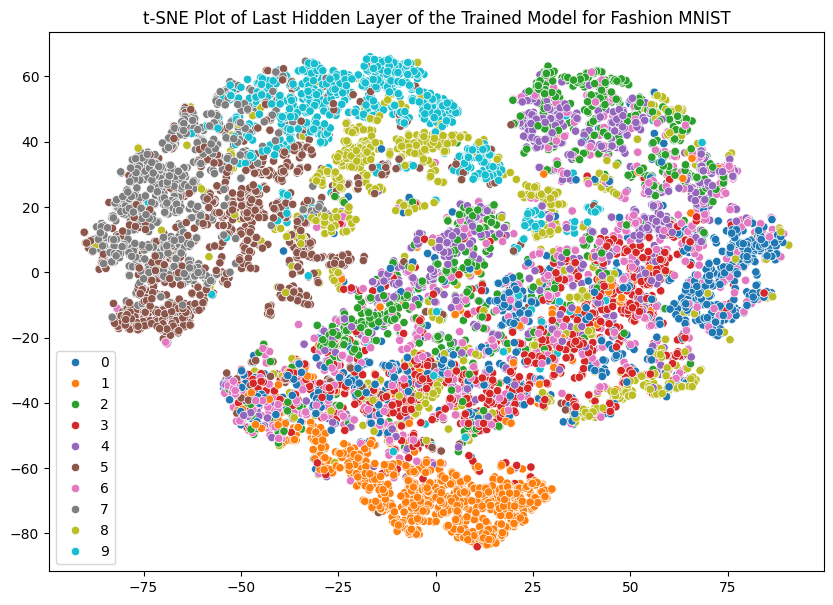

In [40]:
tsne_plot(mlp, x_test_t_reshaped, y_test_t, "t-SNE Plot of Last Hidden Layer of the Trained Model for Fashion MNIST")

#### $Observations$

If we compare the confusion matrix for the MNIST and Fashion-MNIST dataset, we can see that the model has performed better on the MNIST dataset than on the Fashion-MNIST dataset. This is because the network is trained to classify the digits but the Fashion-MNIST dataset contains images of different types of clothing and accessories. The network is not trained to classify these images and hence the confusion matrix is messed up.